In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Reading the data

In [2]:
train_data = pd.read_parquet(r"D:\Analytixlabs\Internship\Project 4\Cyber Security\output\train_data.parquet")
test_data = pd.read_parquet(r"D:\Analytixlabs\Internship\Project 4\Cyber Security\output\test_data.parquet")

# Independent Varaibles and Target Variables

In [3]:
# Independent Variables
Xtrain = train_data.drop(columns = ['label','attack','attack_type']).copy()
Xtest = test_data.drop(columns = ['label','attack','attack_type']).copy()

# Dependent Variables
y_attack_train = train_data['attack'].copy()
y_label_train = train_data['label'].copy()
y_type_train = train_data['attack_type'].copy()

y_attack_test = test_data['attack'].copy()
y_label_test = test_data['label'].copy()
y_type_test = test_data['attack_type'].copy()

In [4]:
del train_data
del test_data

# **Machine Learning Pipeline**

### Model: 1

In [5]:
# Defining the ML Pipeline
pipeline1 = Pipeline(
    steps = [
        ('model', XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=500,
            learning_rate=0.01,
            max_depth=3,
            min_child_weight=6,
            subsample=0.7,
            colsample_bytree=0.7,
            gamma=0.3,
            reg_alpha=0.5,
            reg_lambda=2.0,
            tree_method="hist",
            n_jobs=-1,
            random_state=42,
            max_delta_step=1))
    ]
)

# Fitting to the Pipeline
pipeline1.fit(Xtrain, y_attack_train)

# Predicting the target
ytrain_pred1 = pipeline1.predict(Xtrain)
ytest_pred1 = pipeline1.predict(Xtest)

#Train Test Data Performance
print('Train Data Performance:')
print(metrics.classification_report(y_attack_train, ytrain_pred1))
print('Test Data Performance:')
print(metrics.classification_report(y_attack_test, ytest_pred1))

Train Data Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1467538
           1       0.99      0.95      0.97    298115

    accuracy                           0.99   1765653
   macro avg       0.99      0.97      0.98   1765653
weighted avg       0.99      0.99      0.99   1765653

Test Data Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    628946
           1       0.99      0.95      0.97    127763

    accuracy                           0.99    756709
   macro avg       0.99      0.97      0.98    756709
weighted avg       0.99      0.99      0.99    756709



In [6]:
ytest_proba1 = pipeline1.predict_proba(Xtest)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_attack_test, ytest_proba1)
auc_score1 = metrics.roc_auc_score(y_attack_test, ytest_proba1)

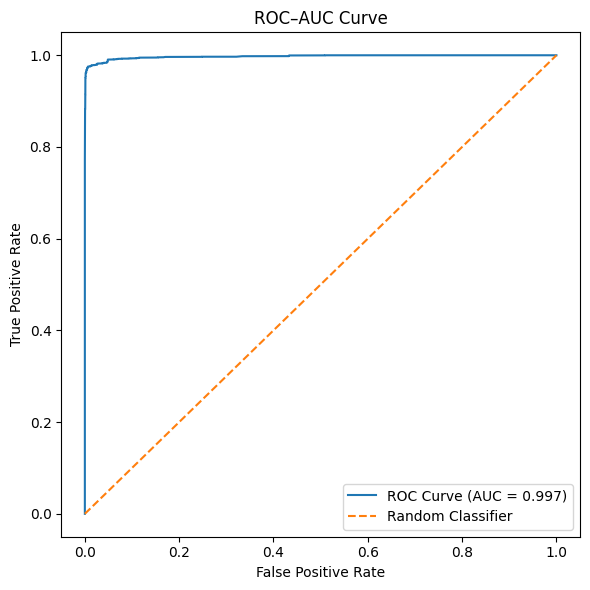

In [7]:
# ROC-AUC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr1, tpr1, label = f"ROC Curve (AUC = {auc_score1:.3f})")
plt.plot([0, 1], [0, 1], linestyle = "--", label = "Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
ytrain_proba1 = pipeline1.predict_proba(Xtrain)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_attack_train, ytrain_proba1)
j_scores1 = tpr1 - fpr1
best_threshold1 = thresholds1[np.argmax(j_scores1)]
best_threshold1

0.33997458

In [9]:
y_pred = (ytrain_proba1 >= best_threshold1).astype(int)
print(metrics.confusion_matrix(y_attack_train, y_pred))
print(metrics.classification_report(y_attack_train, y_pred))

[[1458258    9280]
 [   7052  291063]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1467538
           1       0.97      0.98      0.97    298115

    accuracy                           0.99   1765653
   macro avg       0.98      0.99      0.98   1765653
weighted avg       0.99      0.99      0.99   1765653



In [10]:
precision1, recall1, thresholds1 = metrics.precision_recall_curve(y_attack_train, ytrain_proba1)
f1_scores1 = 2 * (precision1[:-1] * recall1[:-1]) / (precision1[:-1] + recall1[:-1])
best_idx1 = np.argmax(f1_scores1)
best_threshold1 = thresholds1[best_idx1]
best_threshold1

0.41144335

In [11]:
y_pred = (ytrain_proba1 >= best_threshold1).astype(int)
print(metrics.confusion_matrix(y_attack_train, y_pred))
print(metrics.classification_report(y_attack_train, y_pred))

[[1463079    4459]
 [   9216  288899]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1467538
           1       0.98      0.97      0.98    298115

    accuracy                           0.99   1765653
   macro avg       0.99      0.98      0.99   1765653
weighted avg       0.99      0.99      0.99   1765653



In [12]:
import joblib

In [15]:
model = joblib.dump(pipeline1, r'D:\Analytixlabs\Internship\Project 4\Cyber Security\app\model\xgboost_pipeline.pkl' )

In [17]:
len(pipeline1.feature_names_in_)

77

In [18]:
from sklearn.model_selection import train_test_split

In [26]:
sample, yt = train_test_split(Xtest, train_size = 0.00013, stratify = y_attack_test)

In [19]:
Xtest.shape

(756709, 77)

In [21]:
y_attack_test

0         0
1         0
2         1
3         0
4         0
         ..
756704    0
756705    0
756706    0
756707    1
756708    0
Name: attack, Length: 756709, dtype: int32

In [27]:
sample

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
610192,80.0,97377.0,4.0,5.0,431.0,2267.0,431.0,0.0,107.750000,215.500000,...,1.0,32.0,0.0,0.000,0.0,0.0,0.0,0.0000,0.0,0.0
233155,443.0,10269373.0,20.0,27.0,1263.0,38878.0,515.0,0.0,63.150000,148.815773,...,4.0,32.0,218555.0,0.000,218555.0,218555.0,10000000.0,0.0000,10000000.0,10000000.0
641570,50274.0,1021.0,2.0,1.0,12.0,6.0,6.0,6.0,6.000000,0.000000,...,1.0,20.0,0.0,0.000,0.0,0.0,0.0,0.0000,0.0,0.0
481968,80.0,100015721.0,9.0,6.0,306.0,11595.0,306.0,0.0,34.000000,102.000000,...,1.0,32.0,1984.0,0.000,1984.0,1984.0,99900000.0,0.0000,99900000.0,99900000.0
649777,80.0,85330032.0,7.0,6.0,331.0,11595.0,325.0,0.0,47.285714,122.480902,...,2.0,20.0,5.0,0.000,5.0,5.0,85200000.0,0.0000,85200000.0,85200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627455,53.0,60848.0,1.0,1.0,58.0,282.0,58.0,58.0,58.000000,0.000000,...,0.0,40.0,0.0,0.000,0.0,0.0,0.0,0.0000,0.0,0.0
249547,53.0,30904.0,2.0,2.0,148.0,312.0,74.0,74.0,74.000000,0.000000,...,1.0,20.0,0.0,0.000,0.0,0.0,0.0,0.0000,0.0,0.0
665360,123.0,110.0,2.0,2.0,96.0,96.0,48.0,48.0,48.000000,0.000000,...,1.0,20.0,0.0,0.000,0.0,0.0,0.0,0.0000,0.0,0.0
752687,443.0,62992621.0,333.0,801.0,7706.0,1616694.0,1193.0,0.0,23.141141,160.791532,...,8.0,32.0,894721.4,1059272.997,2651843.0,15319.0,9774655.0,956107.3029,10200000.0,8065424.0


In [28]:
sample.to_csv(r'D:\Analytixlabs\Internship\Project 4\Cyber Security\output\sample.csv')

In [14]:
pipeline1.named_steps['model'].feature_importances_

array([0.00968727, 0.00438763, 0.01252532, 0.00196459, 0.00414352,
       0.02026887, 0.03444368, 0.        , 0.01260884, 0.00014349,
       0.00888678, 0.01394614, 0.11340778, 0.10158493, 0.03563916,
       0.0123846 , 0.01088771, 0.00771449, 0.        , 0.00382061,
       0.00929861, 0.00648882, 0.        , 0.01067825, 0.00684389,
       0.00238931, 0.00227456, 0.00480355, 0.00030394, 0.00048783,
       0.        , 0.        , 0.        , 0.        , 0.03599765,
       0.        , 0.01519123, 0.0012615 , 0.03640665, 0.0120288 ,
       0.02373051, 0.02797586, 0.00287112, 0.        , 0.        ,
       0.00776596, 0.02656651, 0.0915757 , 0.        , 0.        ,
       0.00013913, 0.07692248, 0.00129797, 0.0992114 , 0.00221527,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01278604, 0.0037219 , 0.00172023, 0.02615911,
       0.0057009 , 0.00541562, 0.00107151, 0.01394244, 0.00043882,
       0.00401732, 0.0003637 , 0.00018796, 0.01130258, 0.     

In [15]:
Xtrain.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes_per_sec', 'flow_packets_per_sec',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'bwd_header_length',
       'fwd_packets_per_sec', 'bwd_packets_per_sec', 'min_packet_length',
       'max_packet_length', 'packet_length_mean', 'packet_length_std',
       'packet_length_variance', 'fin_flag_count', 'syn_flag_count'

In [30]:
feature_imp = pd.DataFrame()
feature_imp['Features'] = pipeline1.named_steps['model'].feature_names_in_
feature_imp['Importance'] = pipeline1.named_steps['model'].feature_importances_

In [31]:
feature_imp

,Features,Importance
0,destination_port,0.009687
1,flow_duration,0.004388
2,total_fwd_packets,0.012525
3,total_backward_packets,0.001965
4,total_length_of_fwd_packets,0.004144
...,...,...
72,active_min,0.000188
73,idle_mean,0.011303
74,idle_std,0.000000
75,idle_max,0.000000


In [43]:
feature_imp = feature_imp.sort_values(by = 'Importance', ascending = False).reset_index(drop = True)

In [44]:
feature_imp

,Features,Importance
0,bwd_packet_length_mean,0.113408
1,bwd_packet_length_std,0.101585
2,avg_bwd_segment_size,0.099211
3,urg_flag_count,0.091576
4,average_packet_size,0.076922
...,...,...
72,ece_flag_count,0.000000
73,cwe_flag_count,0.000000
74,flow_iat_max,0.000000
75,fwd_iat_std,0.000000


In [45]:
feature_imp.to_csv(r'D:\Analytixlabs\Internship\Project 4\Cyber Security\output\feature_importance.csv', index = False)